# Measuring Churn
Juan Malaver  
eCapital Advisors, LLC  
Data Science Consultant  
jmalaver@ecapitaladvisors.com

Churn can be defined in different ways to suit different business contexts. We can calculate churn directly from a relatively raw database containing recurring billing cycle data for each customer. We'll use credit cards as a reference for this and all subsequent notebooks, though the concepts can be applied to any product involving churn. There are some complexities that arise when calculating churn:
- accounts can churn more than once (e.g. periods of credit card inactivity can occur multiple times)
- accounts can hold multiple products (e.g. one person may have multiple credit cards, debit cards, etc.)  

Raw data will not have a column indicating churn explicitly, especially since churn is measured at a specific point in time. Churn data is sensitive as well, which is why the data used in these notebooks was simulated using scripts from Carl Gold's book ***Fighting Churn With Data: Science and strategy for keeping your customers***. When extracting data from the database, it is also important that data scientists do not have access to *personally identifiable information* (PII). Billing cycle data will almost surely be significantly large, so to calculate churn, it is more efficient to implement the logic in the ETL process rather than extract the data and implementing the logic afterwards. To achieve this, we can use *SQL statements* to scale our approach to very large datasets.

### Data Import and Packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [54]:
%run '../credentials/settings.py'
import os

# obtaining credentials (stored as environmental variables in .env file)
USER = os.getenv('CHURN_DB_USER')
PASS = os.getenv('CHURN_DB_PASS')
IP = os.getenv('CHURN_DB_IP')
PORT = os.getenv('CHURN_DB_PORT')
DB = os.getenv('CHURN_DB_NAME')

In [55]:
from sqlalchemy import create_engine

# SQL engine and connection
engine = create_engine('postgresql+psycopg2://{}:{}@{}:{}/{}'.format(USER, PASS, IP, PORT, DB))
connection = engine.connect()

# printing table names
print(engine.table_names(schema='churnsim'))

['event', 'subscription', 'event_type', 'metric', 'metric_name', 'active_period', 'observation', 'active_week', 'account']


## Churn Rate

Imagine observing the pools of credit cardholders at two different points in time: $start$ and $end$. We might care either about how many cardholders there are, or how much revenue they generate, but for now we'll focus on revenue. At $start$, the pool is composed of both $churn$ customers and $retained$ customers. At $end$, the pool is composed of newly acquired customers and the same $retained$ customers from $start$, implying an overlap between the two pools.

### Calculations

The formula for churn rate based on the previous logic is

$$ChurnRate=\frac{churn}{start}$$  

where $start$ and $churn$ are as defined before. $ChurnRate$ is not derived from the customers at the $end$ time period because newly acquired customers are separate from the issue of churn. This is why churn rate only uses customers in $start$.

$$RetentionRate=\frac{retained}{start}$$

### Connecting churn and retenion

As we mentioned before, $start$ is composed of both $churn$ and $retained$ customers:

$$start=churn+retained$$  

We can do some algebraic manipulation and divide both sides by $start$:

$$\frac{start}{start}=\frac{churn}{start}+\frac{retained}{start}$$  
$$100\%=ChurnRate+RetentionRate$$  

This means that $churn$ and $retained$ are two disjoint sets that partition the sample space $start$ of all customers at a given point in time. $ChurnRate$ is what we want to decrease.

## Database

To calculate churn, we will need a database that tracks customers' billing cycles. This database is structured by specific key variables.

| Column | Data type |
| ----------- | ----------- |
| account_id | int |
| product_id | int |
| start_date | date |
| end_date | date |  

Of course we expect a real database to have many more columns than the ones mentioned, but these are essential fields needed for this specific dataframe structure.

- `account_id` - unique key for each account
- `product_id` - unique key for each product
- `start_date` - start of billing cycle
- `end_date` - end of billing cycle  

A credit card account is opened by a customer, beginning on a specific date and being charged recurringly at each billing cycle. If the billing cycle is stil in progess, then there is no end date. This data is often messy, so we will write out SQL scripts carefully to catch as many irregularities in the data as possible.

## Net Retention

The *Net retention rate* (NRR) is the proportion of customer revenue recevied at $end$ from customers who were part of $start$. Like $ChurnRate$, NRR is not derived from newly acquire customers and their revenue. NRR incorporates changes in revenue from $retained$ customers, which is important for credit cards because customer revenue depends on usage.

### Calculations

$$NetRetention=\frac{MRR_{retained}}{MRR_{start}}$$  

where $MRR$ is monthly recurring revenue from all customers in $retained$ and $start$ respectively. For credit cards, $MRR$ will almost always be different for each customer every billing cycle. $MRR$ also depends on the product itself: a financial institution can offer different credit cards, each with different revenue models. Some considerations about NRR:

- $NetRetention$ is based on $MRR$ so customers who generate more revenue will have bigger impact on $NetRetention$ if they churn
- When $MRR$ changes for retained customers, $NetRetention$ is also impacted  

We can also calculate $NetChurn$ in a similar logic as before:

$$NetChurn=100\% - \frac{MRR_{retained}}{MRR_{start}}$$  

### SQL net retention

To calculate net churn, a SQL program will follow a specific logic:

1. Set start and end dates
2. Identify customers and their revenue at start
3. Identify customers and their revenue at end
4. Identify retained customers and their revenue
5. Divide retained customer revenue by start customer revenue  

In [179]:
# SQL statement
stmt = '''
WITH
-- period for calculating churn
date_range AS (
    SELECT '2020-03-01'::date AS start_date, '2020-04-01'::date AS end_date
),
-- CTE with active accounts at start and their total revenue
start_accounts AS 
(
    -- MRR is summed to account for cases with multiple products
    SELECT account_id, SUM(mrr) AS total_mrr -- 
    FROM churnsim.subscription s INNER JOIN date_range d ON
        -- Being active means that start date is at or before the date and end date is after the date or null
        s.start_date <= d.start_date 
        AND (s.end_date > d.start_date OR s.end_date IS NULL)
    -- grouping by account so total revenue corresponds to each account
    GROUP BY account_id
),
-- CTE with active accounts at end and their total revenue
end_accounts AS
(
    SELECT account_id, SUM(mrr) AS total_mrr
    FROM churnsim.subscription s INNER JOIN date_range d ON
        s.start_date <= d.end_date
        AND (s.end_date > d.end_date OR s.end_date IS NULL)
    GROUP BY account_id
),
-- CTE with retained accounts
retained_accounts AS (
    SELECT s.account_id, SUM(e.total_mrr) AS total_mrr
    FROM start_accounts s
    INNER JOIN end_accounts e ON s.account_id = e.account_id
    GROUP BY s.account_id
),
-- sum of total revenue of accounts at start
start_mrr AS (
    SELECT SUM(start_accounts.total_mrr) AS start_mrr
    FROM start_accounts
),
-- sum of total revenue of retained accounts
retain_mrr AS (
    SELECT SUM(retained_accounts.total_mrr) AS retain_mrr
    FROM retained_accounts
)
SELECT
-- net retention formula
retain_mrr / start_mrr AS net_mrr_retention_rate,
-- net churn formula
    1.0 - retain_mrr / start_mrr as net_mrr_churn_rate,
start_mrr,
retain_mrr
FROM start_mrr, retain_mrr
'''

Let's breakdown each CTE in the SQL statement:

1. `date_range` - one row with start and end dates for calculation
2. `start_accounts` - one row for each active account at start
3. `end_accounts` - one row for each active account at end
4. `retained_accounts` - one row for each active account at both start and end
5. `start_mrr` - one row with total MRR at start
6. `retained_mrr` - one row with total MRR for retained accounts
7. `SELECT` - calculating net retention and net churn  

The final result is shown in the following table.

In [180]:
pd.read_sql(stmt, con=engine)

,net_mrr_retention_rate,net_mrr_churn_rate,start_mrr,retain_mrr
0,0.942336,0.057664,102906.99,96972.93


### Interpretation

The revenue that each customer generates for every billing cycle varies, which means that calculating net retention based on revenue will not be the same as calculating on customer counts. Since revenue can change over time, there are four ways that total revenue can change:

- newly acquired customers
- churned customers
- upsells (retained customers generating higher revenue)
- downsells (retained customers generating lower revenue)  

Upsells can decrease churn, while downsells can increase it. Including downsells makes sense because customers that generate lower revenue are essentially customers that are not as engaged with the product anymore, so the lost revenue from downsells is simply subtracted from the $start$ revenue. Upsells, however, come from the $end$ customer pool, so NRR is no longer derived from two subsets of a greater whole. For this reason, NRR might not be the best way to measure churn, though it is generally useful for external reporting. It is also possible that upsells generate more revenue than the decrease in revenue from churners and downsells, which is known as *negative churn* and is an ideal scenario for any business.

## Account-Based Churn

Account-based churn is not impacted by upsells or downsells.

> *Starndard churn* - proportion of customers who have churned completely

This measure is also known as the *account churn rate*, as it is derived from account activity across products. When calculating the standard churn rate, a customer who cancels one of their credit cards but actively mantains another is not considered a churner.

### Definition

Similar to calculating net churn, the standard churn rate needs a SQL program will follow a specific logic:

1. Set start and end dates
2. Identify and count customers  at start
3. Identify and count customers at end
4. Identify and count churned customers
5. Divide churn count by start count 

### Outer joins

Churned accounts are selected from $start$ and $end$ by using a SQL *outer join*. This is different from using *inner join* as we did in the SQL statement for NRR, which returns all matching rows in both tables. An outer join returns all rows from one table, even if there is no matching row in the other table. We need this logic for the standard churn rate because we want to find the accounts that were part of $start$, but not part of $end$. An inner join would return accounts that are in both pools, while and outer join will return all accounts from $start$, both the ones that churned and the retained accounts. In SQL, we find churners by using a `WHERE` clause to filter for accounts where the `account_id` is null at $end$.

### SQL standard churn

In [183]:
# SQL statement
stmt = '''
WITH
-- period for calculating churn
date_range AS (
    SELECT '2020-03-01'::date AS start_date, '2020-04-01'::date AS end_date
),
-- CTE with active accounts at start
start_accounts AS 
(
    -- Distinct query used for accounts with multiple products
    SELECT DISTINCT account_id
    FROM churnsim.subscription s INNER JOIN date_range d ON
        s.start_date <= d.start_date 
        AND (s.end_date > d.start_date OR s.end_date IS NULL)
),
-- CTE with active accounts at end
end_accounts AS
(
    SELECT DISTINCT account_id
    FROM churnsim.subscription s INNER JOIN date_range d ON
        s.start_date <= d.end_date
        AND (s.end_date > d.end_date OR s.end_date IS NULL)
),
-- CTE with churned accounts
churned_accounts AS (
    SELECT s.account_id
    FROM start_accounts s
    -- outer join includes all records at start
    LEFT OUTER JOIN end_accounts e ON
    -- accounts are matched by their id and filled with NULL for end accounts if there is no match
    s.account_id = e.account_id
    -- where clause removes records with no churn (non-null account_id)
    WHERE e.account_id IS NULL
),
-- count of active accounts at start
start_count AS (
    SELECT COUNT(*) AS n_start FROM start_accounts
),
-- count of churned accounts
churn_count AS (
    SELECT COUNT(*) AS n_churn FROM churned_accounts
)
SELECT
-- churn rate formula
n_churn::float / n_start::float
        AS churn_rate,
    -- retention rate formula
    1.0-n_churn::float / n_start::float
        AS retention_rate,
n_start,
n_churn
FROM start_count, churn_count
'''

Like before, let's breakdown each CTE:

1. `date_range` - one row with start and end dates for calculation
2. `start_accounts` - one row for each active account at start
3. `end_accounts` - one row for each active account at end
4. `churned_accounts` - one row for each account active at start but not active at end
5. `start_count` - one row with total count at start
6. `churn_count` - one row with total count of churned accounts
7. `SELECT` - calculating standard churn rate 

The final result is shown in the following table.

In [184]:
pd.read_sql(stmt, con=engine)

,churn_rate,retention_rate,n_start,n_churn
0,0.057664,0.942336,10301,594


### Interpretation

The standard churn rate is preferred when all customer pay similar amounts recurringly. If all customers pay the *exact* same amount, then net retention and standard churn are the same. For credit cards, customers generate different revenue not only between each other but across time as well. Whether it's appropriate to use standard churn in a credit card scenario depends on the variation of revenue for all accounts. Churn analysis creates models to predict churn, which means that an accurate predictive model should be able to predict churners at the same rate as the standard churn rate. On the other hand, if the variation in revenue is significant, then standard churn rate is not appropriate.

## Activity Churn

We can also calculate churn on customer activity, which depends not on whether a customer is billed on a given cycle, but instead on the event activity during a specific period of time. To calculate activity churn, we need to differentiate between customers that are active and those that are inactive (or churners). We will use a different dataset for this, which tracks the events in a customer's lifespan. In the context of credit cards, this is a transactional database that tracks all activity and records when each transaction took place. 

### Definition

An *active* customer is on that has used the product at least one in a recent period of time. User activity often occurs in clusters, so we define a period as active when there is not large gap between two events. For example, an active period is one where the gaps two successive transacations are small. If the maximum threshold for a gap between two successive events occurs, then that is considered a churn event. We can also add additional flavor to this definition with restrictions like

- active periods occur only of specific events occurs (e.g. credit card merchandise transaction)
- active periods occur only if a minimum number of events occur (e.g. at least 5 transactions)
- active periods occur only if they pass a metric test (e.g. minimum spend of \$10)

### SQL activity churn

We will not use the billing cycle table for activity churn, but rather an event table. An account will be considered active if there exists a recent event in their history. We will calculate this on a monthly basis, and we will need to detect whether events occured in the last month. The logic is as follows:

1. Identify active accounts at start (an event occured within the last month before the start date)
2. Identify active accounts an end (an event occured within a window of time that ends at the end date)
3. Outer join between accounts to identify churned accounts
4. Dive number of churned accounts by number of active accounts at start

In [201]:
# SQL statement
stmt = '''
WITH
-- period for calculating churn
date_range AS (
    -- events use timestamps instead of dates
    SELECT '2020-03-01'::TIMESTAMP AS start_date,
        '2020-04-01'::TIMESTAMP AS end_date,
        interval '1 months' AS inactivity_interval
),
-- CTE with active accounts at start
start_accounts AS 
(
    SELECT DISTINCT account_id
    FROM churnsim.event e INNER JOIN date_range d ON
        e.event_time > start_date - inactivity_interval 
        AND e.event_time <= start_date
),
-- count of active accounts at start
start_count AS
(
    SELECT COUNT(start_accounts.*) AS n_start FROM start_accounts
),
-- CTE with active accounts at end
end_accounts AS 
(
    SELECT DISTINCT account_id
    FROM churnsim.event e INNER JOIN date_range d ON
        e.event_time > end_date - inactivity_interval 
        AND e.event_time <= end_date
),
-- count of active accounts at end
end_count AS
(
    SELECT COUNT(end_accounts.*) AS n_end FROM end_accounts
),
-- CTE with churned accounts
churned_accounts AS 
(
    SELECT DISTINCT s.account_id
    FROM start_accounts s
    LEFT OUTER JOIN end_accounts e ON s.account_id = e.account_id
    WHERE e.account_id IS NULL
),
-- count of churned accounts
churn_count AS (
    SELECT COUNT(churned_accounts.*) AS n_churn 
    FROM churned_accounts
)
SELECT
n_churn::float / n_start::float AS churn_rate,
    1.0-n_churn::float / n_start::float AS retention_rate,
n_start,
n_churn
FROM start_count, end_count, churn_count
'''

One of the main differences between churn calculated on billing cycles and churn calculated on event data is that activity churn requires a wait time before we can identify a customer as a churner or not. With billing cycles, we know when a customer has churned if we can assert that they will not use the product in the next cycle (e.g. closed the account, account expiration, etc.). When we calculate churn based on activity however, we will not know if a transacation will be a customer's last transaction until we wait for some time and observe zero transactions during that time. The output of the SQL statement is shown below.

In [202]:
pd.read_sql(stmt, con=engine)

,churn_rate,retention_rate,n_start,n_churn
0,0.064575,0.935425,10964,708


## Monthly Recurring Revenue Churn 

The standard churn rate ignores downsells, which are part of churn, but the net retention rate includes both downsells and upsells, the latter of which is not a part of churn. We use MRR churn to address both of these flaws, and it is the most accurate measure when accounts can have multiple products and have varying revenue streams in each of those products.

### Definition and calculations

MRR Churn is the proportion of losses when compared to the start_date, but MRR churn incorporates losses from both churn and downsells. This means that MRR includes losses from outright churns, but also from customers who are generating less revenue then they were at the start (e.g. less activity).

$$MRRChurn=\frac{MRR_{churn}+MRR{downsell}}{MRR_{start}}$$  

### SQL MRR churn

To calculate MRR churn using SQL, we use elements from both net retentions and standard churn calculations. The logic is as follows:

1. Set start and end dates
2. Identify customers and total revenue at start
3. Identify customers at end
4. Identify churned customers and their revenue
5. Identify downsell customer and amounts
6. Divide total churned revenue and downsell revenue by start revenue

The script itself will make use of the following CTEs:

1. `date_range` - one row with start and end dates
2. `start_accounts` - one row for each active account at start
3. `end_accounts` - one row for each active account at end
4. `churned_accounts` - one row for each churned account
5. `downsell_accounts` - one row for each account with lower mrr at end than start
6. `start_mrr` - one row with total MRR at start
7. `churn_mrr` - one row with total MRR for churned accounts
8. `downsell_mrr` - one row with total MRR for retained accounts
6. `SELECT` - calculate MRR churn

In [192]:
# SQL statement
stmt = '''
WITH
-- period for calculating churn
date_range AS (
    SELECT '2020-03-01'::date AS start_date, '2020-04-01'::date AS end_date
),
-- CTE with active accounts at start
start_accounts AS 
(
    -- Distinct query used for accounts with multiple products
    SELECT account_id, SUM(mrr) AS total_mrr
    FROM churnsim.subscription s INNER JOIN date_range d ON
        s.start_date <= d.start_date 
        AND (s.end_date > d.start_date OR s.end_date IS NULL)
    GROUP BY account_id
),
-- CTE with active accounts at end
end_accounts AS
(
    SELECT account_id, SUM(mrr) AS total_mrr
    FROM churnsim.subscription s INNER JOIN date_range d ON
        s.start_date <= d.end_date
        AND (s.end_date > d.end_date OR s.end_date IS NULL)
    GROUP BY account_id
),
-- CTE with churned accounts
churned_accounts AS (
    SELECT s.account_id, SUM(s.total_mrr) 
        AS total_mrr
    FROM start_accounts s
    -- outer join includes all records at start
    LEFT OUTER JOIN end_accounts e ON
    -- accounts are matched by their id and filled with NULL for end accounts if there is no match
    s.account_id = e.account_id
    -- where clause removes records with no churn (non-null account_id)
    WHERE e.account_id IS NULL
    GROUP BY s.account_id
),
-- CTE with downsell accounts
downsell_accounts AS
(
    SELECT s.account_id, s.total_mrr-e.total_mrr
        AS downsell_amount
    FROM start_accounts s
    -- inner join selects accounts active at both beginning and end
    INNER JOIN end_accounts e ON s.account_id=e.account_id
    -- where clause selects accounts generating less revenue at end
    WHERE e.total_mrr < s.total_mrr
),
-- total MRR from active accounts at start
start_mrr AS (
    SELECT SUM(start_accounts.total_mrr) AS start_mrr 
    FROM start_accounts
),
-- total MRR from churned accounts
churn_mrr AS (
    SELECT SUM(churned_accounts.total_mrr) AS churn_mrr 
    FROM churned_accounts
),
-- total MRR from downsell accounts
downsell_mrr AS (
    -- coalesce fills zeros where there are no downsells
    SELECT coalesce(SUM(downsell_accounts.downsell_amount), 0.0)
        AS downsell_mrr
    FROM downsell_accounts
)
SELECT
    -- MRR churn formula
    (churn_mrr+downsell_mrr) / start_mrr AS mrr_churn_rate,
start_mrr,
churn_mrr,
downsell_mrr
FROM start_mrr, churn_mrr, downsell_mrr
'''

In [193]:
pd.read_sql(stmt, con=engine)

,mrr_churn_rate,start_mrr,churn_mrr,downsell_mrr
0,0.057664,102906.99,5934.06,0.0


### Interpretation

So far we have learned three ways to calculate churn: net churn, standard churn, and MRR churn. We can summarize when each metric is most appropriate:

- *Net churn* - external reporting metric to investors (equivalent to standard churn if all customers generate the same revenue)
- *Standard churn* - customers generate relatively similar revenue, but the amounts are different enough to significantly impact net retention
- *MRR churn* - customers generate significantly different revenue  

MRR churn is very useful when the variation in customer revenue is large, which is often the case with credit cards: some cardholders have much higher utilization rates than others. The formula might suggest that MRR churn is always larger than standard churn, but this is not necessarily true because accounts that generate more revenue tend to churn at a lower rate than accounts that generate less revenue. In other words, accounts that generate the lowest revenue are the ones most likely to churn. For example, a credit cardholder who usually carries a high balance between billing cycles is more committed to using the credit card for a longer time. This is because customers with these kinds of spending habits are more deliberate in the way they use the credit card (i.e. the credit card is more present in their lives). Net churn tends to be the lowest of all measures beecause it also counts upsells for retained accounts and weighs that against the churn rate. 

## Measurement Conversion

All the calculations done with the SQL statements in this notebook generated a churn metric over a single month. We can technically calculate churn over any time period, whether that be annually, quarterly, or other appropriate intervals. The calculation doesn't change when we change the time interval. There will be cases however, when we might want to know the annual churn rate even though that year is not over, or a product was recently launched in March and we want to know its churn performance over the year. The relationship between monthly churn and annual churn is a bit more complex than it might seem at first glance.

### Survivor analysis

Every month, if a customer does not churn, they are considered a *survivor*. We care about how many customers can survive over multiple months, which we can summarize mathematically with the following logic:

1. Given $N$ customers at the start fo the first month and monthly churn rate $c$, $cN$ customers churn on the first month and $(1-c)N=rN$ customers remain, for retention rate $r$.
2. Month 2 starts with $rN=(1-c)N$ customers, and $c(1-c)N$ churn during that month. After month 2, there are $(1-c)N - c(1-c)N$ accounts remaining, which simplifies to

$$(1-c)N\times(1-c)=(1-c)^2N=r^2N$$  

3. Month 3 starts with $r^2N=(1-c)^2N$ accounts and $c(1-c)^2N$ churn during that month. After month 3, there are $(1-c)^2N - c(1-c)^2N$ accounts remaining, which simplifies to 

$$(1-c)^2N\times(1-c)=(1-c)^3N=r^3N$$ 

4. Continuing this patttern for $x$ months, we know that after month $x$ the number of remaining accounts is

$$(1-c)^xN=r^xN$$

### Converting churn rates

Using the formula from survivor analysis, we can convert monthly churn rates into annual churn rates. The number of retained customers after one year is

$$N_{year}=r^{12}N=(1-c)^{12}N$$  

We can define $R=r^{12}$ as the annual retention rate, which we can multiply by the number of customers at the start to get the number of customers at the end of the year. We can also derive the annual churn rate $C$ from $R$ as

$$C=100\%-R=100\%-(1-c)^{12}$$  

We can also convert an annual retention rate to a monthly retention rate using algebra:

$$r=\sqrt[12]{R}=R^{1/12}$$

Similarly, we can also derive the monthly churn rate from an annual churn rate:

$$c=100\%-\sqrt[12]{1-C}=100\%-(1-C)^{12}$$

### SQL conversions

We can use SQL to make any churn rate conversions between any time windows. For example, we might want to measure churn rate for a credit card that was first released less than a year ago and we want to use as much data as possible. For any churn rate $c'$ made over $p$ days, the equivalent annual churn rate $C$ is

$$C=100\%-(1-c')^{365/p}$$  

Using a similar logic, we can also calculate a monthly churn rate $c$ from $c'$:

$$c=100\%-(1-c')^{(365/12)p}$$

In [205]:
stmt='''
WITH
-- period for calculating churn
date_range AS (
    SELECT '2020-03-01'::date AS start_date, '2020-06-01'::date AS end_date
),
-- CTE with active accounts at start
start_accounts AS 
(
    -- Distinct query used for accounts with multiple products
    SELECT DISTINCT account_id
    FROM churnsim.subscription s INNER JOIN date_range d ON
        s.start_date <= d.start_date 
        AND (s.end_date > d.start_date OR s.end_date IS NULL)
),
-- CTE with active accounts at end
end_accounts AS
(
    SELECT DISTINCT account_id
    FROM churnsim.subscription s INNER JOIN date_range d ON
        s.start_date <= d.end_date
        AND (s.end_date > d.end_date OR s.end_date IS NULL)
),
-- CTE with churned accounts
churned_accounts AS (
    SELECT s.account_id
    FROM start_accounts s
    -- outer join includes all records at start
    LEFT OUTER JOIN end_accounts e ON
    -- accounts are matched by their id and filled with NULL for end accounts if there is no match
    s.account_id = e.account_id
    -- where clause removes records with no churn (non-null account_id)
    WHERE e.account_id IS NULL
),
-- count of active accounts at start
start_count AS (
    SELECT COUNT(*) AS n_start FROM start_accounts
),
-- count of churned accounts
churn_count AS (
    SELECT COUNT(*) AS n_churn FROM churned_accounts
)
SELECT
    -- number of customers at start
    n_start,
    -- number of customers that churned
    n_churn,
-- standard churn rate
n_churn::float/n_start::float AS measured_churn,
-- difference in days between start and end
end_date-start_date AS period_days,
1.0-POWER(1.0-n_churn::float/n_start::float, 365.0 / (end_date-start_date)::float)
    AS annual_churn,
1.0-POWER(1.0-n_churn::float/n_start::float, (365.0/12.0) / (end_date-start_date)::float)
    AS monthly_churn
FROM start_count, churn_count, date_range
'''

In [206]:
pd.read_sql(stmt, con=engine)

,n_start,n_churn,measured_churn,period_days,annual_churn,monthly_churn
0,10301,1397,0.135618,92,0.439098,0.047042


### Picking a measurement window

Baseline churn rates should be measured for the same time windows as the time between billing cycles. If the churn rate needs to be scaled further, then we can use the formulas specified above. If the time frame for measuring churn rates is larger that of billing cycles (monthly for credit cards), then the churn rate is not including accounts that were booked and that churned between the start and end dates. This is because churn rates are calculated by looking at accounts at two specific points in time: start and end. It is important that churn rates are measured in the same time windows as billing cycles to avoid errors in the aggregations. 

### Seasonality

If churn rates are calculated on a monthly basis, which is we we concluded we should do with credit cards in the previous section, then seasonality can also generate some issues.

> *Seasonality* - variations in time series data that occur at different points of the year  

It is common to observe seasonality in churn rate calculations, where the churn rate might move up and down at different points of the year. When reducing churn, the calculations should be corrected for seasonal trends. This is not a problem when calculating annual churn rates, but monthly churn rates will start showing patterns over multiple years of data. When the data has been collected for less than a year, then we are unable to make inference about seasonal patterns as they could be generated by some other exogenous shock unique to that year. To correct for this, we can use statistical time series analysis techniques, but those strategies will be customized to the specific business context. In a general sense, assuming we have at least two years of data, we can look at all accounts that were active within the last year of each date.

1. Find all active accounts in year 1
2. Find all active accounts in year 2
3. Find all churned accounts by comparing the two pools
4. Divide the count of churned accounts by the number of accounts in year one  

This is essentially an annual churn rate calculation that does not miss any accounts that churned within the year. Calculating this for every month allows us to observe the difference in churn between each month and the same month one year before. If accounts are likely to churn and then start using the product again later, however, then it makes more sense to use regular monthly churn rates and control for seasonality using statistical techniques. We can also average monthly churn rates over specifc periods of time (quarters, semesters) and then compare those averages across different years. We can also compare a monthly churn rate to the monthly churn rate for the same month last year.

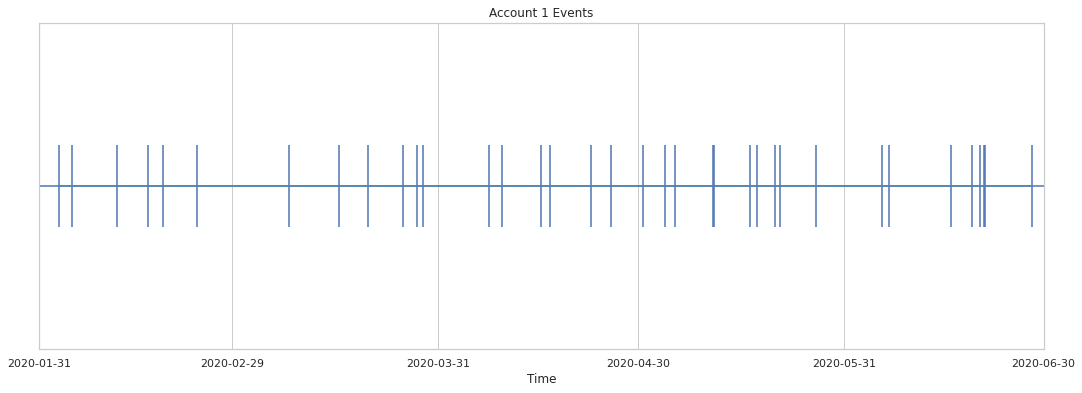

In [177]:
sns.set_style("whitegrid")
two = df[(df['account_id'] == 1) & (df['event_type_id'] == 1)]
fig, ax = plt.subplots(figsize=[18, 6])
g = sns.lineplot(data=two, x='event_time', y='account_id', style='account_id', hue='account_id', palette="Set2", ax=ax, legend=False)
g.set(xticks=pd.date_range(start='2020-01-01', periods=6, freq='M'),yticks=[], ylabel='', xlabel='Time', title='Account 1 Events', xlim=['2020-01-31', '2020-06-30'], ylim=[0.8, 1.2]) 
plt.vlines(two['event_time'], 0.95, 1.05)
plt.axhline(1, 0, 1)
plt.show()